# Basic Raytracing

__raytracing pipeline, raytracing manager__


In [1]:
import vulky as vk

vk.create_device(debug=True)

SCREEN_WIDTH = 2048
SCREEN_HEIGHT = 2048

render_target = vk.image_2D(
    image_format=vk.Format.VEC4,
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT,
    mips=1,  # Important to make the image single resource
    usage=vk.ImageUsage.STORAGE,
    memory=vk.MemoryLocation.GPU
)

data = vk.load_obj('./data/bunny.obj')
vertices_data, indices_data = vk.create_mesh(data, mode='po')

[INFO] Vulkan Instance created...
[INFO] Debug instance created...
[INFO] Available devices: 1
[INFO] Selected device: NVIDIA GeForce RTX 2080 Ti

[INFO] Selected device index: 0

[INFO] 5 available queue family
[PRINT] Inserted device layer "VK_LAYER_KHRONOS_validation" (C:\VulkanSDK\1.3.275.0\Bin\.\VkLayer_khronos_validation.dll)
[PRINT] Inserted device layer "VK_LAYER_OBS_HOOK" (C:\ProgramData\obs-studio-hook\.\graphics-hook64.dll)
[PRINT] Inserted device layer "VK_LAYER_NV_optimus" (C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll)
[PRINT] vkCreateDevice layer callstack setup to:
[PRINT]    <Application>
[PRINT]      ||
[PRINT]    <Loader>
[PRINT]      ||
[PRINT]    VK_LAYER_NV_optimus
[PRINT]            Type: Implicit
[PRINT]                Disable Env Var:  DISABLE_LAYER_NV_OPTIMUS_1
[PRINT]            Manifest: C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\nv-vk64.json
[PRINT]            Librar

In [2]:
triangles_vb = vk.structured_buffer(
    count=len(vertices_data), 
    element_description=dict(
        P=vk.vec3,
        N=vk.vec3,
        C=vk.vec2
    ),
    usage=vk.BufferUsage.RAYTRACING_RESOURCE    
).load(vertices_data)
triangles_ib = vk.structured_buffer(
    count=indices_data.numel(),
    element_description=int,
    usage=vk.BufferUsage.RAYTRACING_RESOURCE
).load(indices_data)

triangles = vk.triangle_collection()
triangles.append(triangles_vb, triangles_ib)
geometry_ads = vk.ads_model(triangles)

instances = vk.instance_buffer(1)
with instances.map(mode='inout') as m:
    m.accelerationStructureReference[0] = geometry_ads.handle
scene_ads = vk.ads_scene(instances)    

scratch_buffer = vk.scratch_buffer(geometry_ads, scene_ads)
    
with vk.raytracing_manager() as man:
    man.build_ads(geometry_ads, scratch_buffer)
    man.build_ads(scene_ads, scratch_buffer)

In [3]:
global_transform = vk.object_buffer(
    vk.Layout.from_structure(
        vk.LayoutAlignment.SCALAR,
        Proj=vk.mat4,
        View=vk.mat4
    ),
    memory=vk.MemoryLocation.GPU
)

with global_transform as b:
    b.Proj = vk.mat4.perspective()
    b.View = vk.mat4.look_at(vk.vec3(0., 1., 4.), vk.vec3(0., 0.5, 0.), vk.vec3(0.,1., 0.))

In [4]:
ray_generation_shader_code = """
#version 460
#extension GL_EXT_ray_tracing : require

layout(set = 0, binding = 0) uniform accelerationStructureEXT Scene;
layout(set = 0, binding = 1) uniform Globals {
    mat4 proj;
    mat4 view;
} globals;
layout(set = 0, binding = 2, rgba32f) uniform image2D ResultImage;

layout(location = 0) rayPayloadEXT vec4 ResultColor;

void main() {
    vec2 uv = (gl_LaunchIDEXT.xy + vec2(0.5)) / vec2(gl_LaunchSizeEXT.xy);
    vec4 P = vec4(uv.x * 2 - 1.0, uv.y * 2 - 1.0, 0.0, 1.0);
    vec4 T = vec4(uv.x * 2 - 1.0, uv.y * 2 - 1.0, 1.0, 1.0);
    mat4 inv_transform = inverse(globals.proj * globals.view); 
    P = inv_transform * P;
    T = inv_transform * T;
    vec3 o = P.xyz / P.w;
    vec3 d = normalize(T.xyz/T.w - o);
    traceRayEXT(Scene, gl_RayFlagsNoneEXT, 0xFF, 0, 0, 0, o, 0.001, d, 1000.0f, 0);
    imageStore(ResultImage, ivec2(gl_LaunchIDEXT.xy), ResultColor);
}  
"""
closest_hit_shader_code = """
#version 460
#extension GL_EXT_ray_tracing : require
#extension GL_EXT_scalar_block_layout : require

layout(location = 0) rayPayloadInEXT vec4 ResultColor;
hitAttributeEXT vec2 HitAttribs;

struct Vertex {
    vec3 P;
    vec3 N;
    vec2 C;
};

layout(scalar, set=0, binding = 3) readonly buffer Vertices {
    Vertex data[];
} vertices;

layout(scalar, set=0, binding = 4) readonly buffer Indices {
    int data[];
} indices;

void main() {
    int triangleIndex = gl_PrimitiveID;
    Vertex v0 = vertices.data[indices.data[triangleIndex*3 + 0]];
    Vertex v1 = vertices.data[indices.data[triangleIndex*3 + 1]];
    Vertex v2 = vertices.data[indices.data[triangleIndex*3 + 2]];
    vec3 coord = vec3(1 - HitAttribs.x - HitAttribs.y, HitAttribs.x, HitAttribs.y);
    vec3 N =  normalize(v0.N * coord.x + v1.N * coord.y + v2.N * coord.z);
    //ResultColor = vec4(N.x, N.y, N.z, 1);
    vec3 light = vec3(3,3,0.3)/3.14159*max(0.1, dot(N, normalize(vec3(2,1,5))));
    ResultColor = vec4(light.x, light.y, light.z, 1);
}
"""
miss_shader_code = """
#version 460
#extension GL_EXT_ray_tracing : require

layout(location = 0) rayPayloadInEXT vec4 ResultColor;

void main() {
    ResultColor = vec4(0.1, 0.1, 0.7, 1.0);
}  
"""

In [5]:
pipeline = vk.pipeline_raytracing()
pipeline.layout(set=0, binding=0, scene=vk.DescriptorType.SCENE_ADS)
pipeline.layout(set=0, binding=1, global_transform=vk.DescriptorType.UNIFORM_BUFFER)
pipeline.layout(set=0, binding=2, output_image=vk.DescriptorType.STORAGE_IMAGE)
pipeline.layout(set=0, binding=3, vertices=vk.DescriptorType.STORAGE_BUFFER)
pipeline.layout(set=0, binding=4, indices=vk.DescriptorType.STORAGE_BUFFER)
with pipeline.shader_stages(vk.ShaderStage.RT_GENERATION):
    gen_shader = pipeline.load_shader_from_source(ray_generation_shader_code)
with pipeline.shader_stages(vk.ShaderStage.RT_MISS):
    miss_shader = pipeline.load_shader_from_source(miss_shader_code)
with pipeline.shader_stages(vk.ShaderStage.RT_CLOSEST_HIT):
    closest_hit_shader = pipeline.load_shader_from_source(closest_hit_shader_code)
gen_group = pipeline.create_rt_gen_group(gen_shader)
hit_group = pipeline.create_rt_hit_group(closest_hit=closest_hit_shader)
miss_group = pipeline.create_rt_miss_group(miss_shader)
pipeline.close()

[INFO] Compiled code for rgen
[INFO] Compiled code for rmiss
[INFO] Compiled code for rchit


In [6]:
rt_program = pipeline.create_rt_program(1, 1, 1, 1)
with rt_program:
    rt_program.set_generation(0, gen_group)
    rt_program.set_hit_group(0, hit_group)
    rt_program.set_miss(0, miss_group)

In [7]:
global_bindings = pipeline.create_descriptor_set_collection(set=0, count=1)
global_bindings[0].update(
    scene = scene_ads,
    global_transform = global_transform,
    output_image = render_target,
    vertices = triangles_vb,
    indices = triangles_ib
)

In [8]:
with vk.raytracing_manager() as man:
    man.set_pipeline(pipeline)
    man.bind(global_bindings[0])
    man.dispatch_rays(rt_program, SCREEN_WIDTH, SCREEN_HEIGHT)

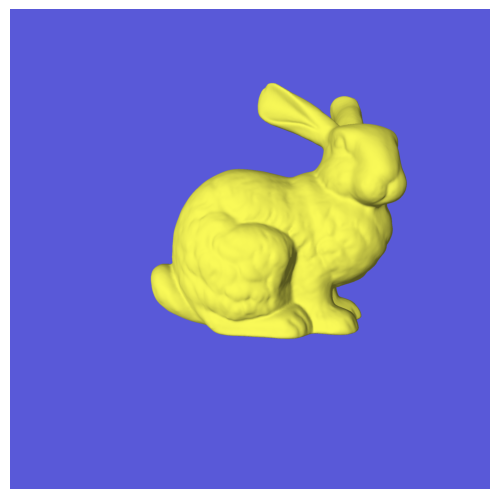

In [9]:
staging = vk.tensor(render_target.height, render_target.width, 4)
render_target.save(staging)
import matplotlib.pyplot as plt
plt.imshow(staging.cpu() ** (1.0/2.2))
plt.gca().axis('off')
plt.gca().invert_yaxis()
plt.tight_layout(pad=0.0)
plt.show()